# Math Q&A Transformer

## Setup

Global variables.

In [1]:
DATASET_FOLDER = 'mathematics_dataset'

## Data

Class for loading data.

In [2]:
import torch
import os


class MathDataset(torch.utils.data.Dataset):
  """
  Represents a particular sub-dataset within the overall Google Math
  Dataset
  """

  @staticmethod
  def root():
    """
    :return: root directory of the dataset
    """
    return os.path.join(DATASET_FOLDER, 'mathematics_dataset-v1.0')

  @staticmethod
  def data_types():
    """
    :return: data types in the dataset (train-easy, train-hard,
    eval, etc.)
    """
    return tuple(
      d for d in os.listdir(MathDataset.root())
      if os.path.isdir(os.path.join(MathDataset.root(), d))
    )

  @staticmethod
  def categories():
    """
    :return: dictionary of data type -> list of categories for each
    data type in the dataset
    """
    categories = {}
    for data_type in MathDataset.data_types():
      data_type_cats = []
      dtype_folder = os.path.join(MathDataset.root(), data_type)
      for file_name in os.listdir(dtype_folder):
        data_type_cats.append(file_name[:file_name.find('__')])
      categories[data_type] = tuple(data_type_cats)

    return categories

  @staticmethod
  def subcategories():
    """
    :return: dictionary of data type -> category -> list of subcategories
    for each category in each data type of the dataset
    """
    subcategories = {}
    for data_type in MathDataset.data_types():
      data_type_subcats = {}
      dtype_folder = os.path.join(MathDataset.root(), data_type)
      for file_name in os.listdir(dtype_folder):
        i_du = file_name.find('__')
        cat, subcat = file_name[:i_du], file_name[i_du + 2 : -4]

        if cat not in data_type_subcats:
          data_type_subcats[cat] = []
        data_type_subcats[cat].append(subcat)

      subcategories[data_type] = data_type_subcats

    return subcategories

  def __init__(self, data_type, category, subcategory):
    """
    Load and initialize the subcategory dataset within the given category
    and data type
    :param data_type: the data type to load from. Must be one of
    MathDataset.data_types()
    :param category: the category to load from. Must be one of
    MathDataset.categories()[data_type]
    :param subcategory: the subcategory dataset to load. Must be one of
    MathDataset.subcategories()[data_type][category]
    """
    self.data_type = data_type
    self.category = category
    self.subcategory = subcategory

    with open(self.path, 'r') as f:
      lines = f.read().splitlines()

    self.questions = lines[::2]
    self.answers = lines[1::2]

  @property
  def path(self):
    """
    :return: Path to the subcategory folder
    """
    folder = os.path.join(MathDataset.root(), self.data_type)
    file_name = f'{self.category}__{self.subcategory}.txt'
    return os.path.join(folder, file_name)

  def __getitem__(self, index):
    """
    :param index: index of question-answer pair in range(len(self))
    :return: The question answer pair in the dataset at the given index
    """
    return self.questions[index], self.answers[index]

  def __len__(self):
    """
    :return: How many question-answer pairs are in the dataset
    """
    return len(self.questions)


Summarize dataset structure for the `arithmetic` category.

In [3]:
for data_type, categories in MathDataset.subcategories().items():
  print(f'Data Type: {data_type}')
  for subcat in categories['arithmetic']:
    print(f'  {subcat}')
  print()

Data Type: extrapolate
  add_or_sub_big
  add_sub_multiple_longer
  div_big
  mixed_longer
  mul_big
  mul_div_multiple_longer

Data Type: interpolate
  add_or_sub
  add_or_sub_in_base
  add_sub_multiple
  div
  mixed
  mul
  mul_div_multiple
  nearest_integer_root
  simplify_surd

Data Type: train-easy
  add_or_sub
  add_or_sub_in_base
  add_sub_multiple
  div
  mixed
  mul
  mul_div_multiple
  nearest_integer_root
  simplify_surd

Data Type: train-hard
  add_or_sub
  add_or_sub_in_base
  add_sub_multiple
  div
  mixed
  mul
  mul_div_multiple
  nearest_integer_root
  simplify_surd

Data Type: train-medium
  add_or_sub
  add_or_sub_in_base
  add_sub_multiple
  div
  mixed
  mul
  mul_div_multiple
  nearest_integer_root
  simplify_surd



Print some example questions and answer.

In [4]:
test_dataset = MathDataset('train-easy', 'arithmetic', 'add_or_sub')

for question, answer in zip(*test_dataset[5000:5005]):
  print(f'Question: {question}')
  print(f'Answer: {answer}')
  print()

Question: What is -15845 minus -35?
Answer: -15810

Question: Work out 0.95 - 2721.
Answer: -2720.05

Question: Sum -20.4 and -0.024.
Answer: -20.424

Question: Calculate -1.4968 + 6.
Answer: 4.5032

Question: What is -0.3 less than 14240?
Answer: 14240.3



## Transformer

Modules needed to implement Transformer.

In [5]:
from typing import List
import torch


class TokenEmbedding(torch.nn.Module):
  """
  Manages the conversion between three different token-string
  representations:

  1. String (human-readable) representation, e.g., 'What is 3 + 4?'

  2. Index (computer-readable) representation, e.g.,
  [start_index, i('W'), i('h'), i('a'), ..., i(' '), i('?'), end_index],
  where i is a function that maps a string representation to an integral
  index.

  3. Vector (ML embedding) representation, e.g.,
  [t(i1), t(i2), ... t(in)], where i1, i2, ..., in are the integral
  indices of the tokens, and t(i) is a vector in R^d for every index i

  - Use TokenEmbedding.indices to convert 1. -> 2.
  - Use TokenEmbedding.unembed to convert 2. -> 1.
  - Use TokenEmbedding.forward to convert 2. -> 3.

  The model decides how to convert 3. -> 2.
  """

  # Indices used for special tokens that are always included
  # in a token set
  start_index = 0
  end_index = 1
  pad_index = 2

  def __init__(self, tokens: List[str], d: int):
    """
    :param tokens: A list of tokens (as strings)
    :param d: Embedding dimension
    """
    super().__init__()

    self.d = d

    # <START> token is always 0, <END> token is always 1,
    # <PAD> token is always 2
    self.tokens = ('<START>', '<END>', '<PAD>') + tuple(tokens)

    # build mapping from token value to token index
    self.index = {t: i for i, t in enumerate(self.tokens)}

    # Store embedding matrix as a Parameter so that it can be
    # learned during training
    self.embedding_matrix = torch.nn.Parameter(
      torch.empty((self.num_tokens, d))
    )

    # I found it difficult to find suggestions on how to initialize
    # the embedding matrix, but PyTorch just samples from N(0,I)
    # (c.f. torch.nn.Embedding), so we will do this as well
    torch.nn.init.normal_(self.embedding_matrix)

  @property
  def num_tokens(self):
    return len(self.tokens)

  def indices(self, x: List[str]):
    """
    :param x: list of B strings of tokens, each of length n_i
    :return: tensor (B, n) of B sets of n token indices, where
    n = 2 + max_i n_i. Sequences are formed by prepending <start>
    tokens and appending <EOS> tokens. Sequences shorter than n tokens
    in length are padded with <pad> tokens
    """
    unpadded = [[self.index[t.lower()] for t in s] for s in x]
    n = max(map(len, unpadded))

    # pad sequences with <START>, <END> and <PAD> tokens
    padded = [
        [self.start_index]
        + s
        + [self.end_index]
        + [self.pad_index] * (n - len(s))
        for s in unpadded
    ]

    return torch.tensor(
        padded, dtype=torch.long, device=self.embedding_matrix.device
    )

  def unembed(self, indices, include_special: bool=False):
    """
    :param indices: (B, n) tensor B sets of n token indices
    :param include_special: Whether to include the special <START>, <END>
    and <PAD> tokens
    :return: the string corresponding to the given token indices
    """
    if include_special:
      return [''.join(self.tokens[i] for i in si) for si in indices]
    else:
      return [
          ''.join(
              self.tokens[i]
              for i in si[1 : si.tolist().index(self.end_index)]
          )
          for si in indices
      ]

  def forward(self, indices):
    """
    :param indices: (B, n) tensor of B sequences of n token indices
    :return: (B, n, d) tensor of B sets of embedded tokens
    """
    unscaled = self.embedding_matrix[indices, :]

    # Vaswani et al. scale embedding weights by sqrt(d)
    return unscaled * (self.d ** .5)


In [6]:
# note that these are the numbers
# max_q_seq_length = 160
# max_a_seq_length = 30
class PositionalEncoding(torch.nn.Module):
  """
  Performs a positional encoding on a sequence of tokens.
  Vaswani et al. section 3.5
  """

  def forward(self, x):
    """
    :param x: (B, n, d) tensor of B sets of n embedded tokens
    :return: (B, n, d) tensor of B sets of n embedded tokens with
    positional encoding
    """
    # make a matrix that is the sum of the input and the matrix of
    # sin and cos PE from 3.5

    # need to update pos

    pe = torch.zeros(x.size())
    b, n, d_model = x.size()

    # require d_model even to make our lives easy
    assert d_model % 2 == 0

    pos = torch.arange(n)
    i = torch.arange(d_model // 2)
    large_num = 10000 ** (2 * i / d_model)
    angle = pos[:, None] / large_num[None, :]
    pe[:, :, ::2] = torch.sin(angle)
    pe[:, :, 1::2] = torch.cos(angle)

    return x + pe.to(x.device)


In [7]:
class FeedForwardNetwork(torch.nn.Module):
  """
  A 2-layer feed-forward neural network.
  Vaswani et al. section 3.3
  """

  def __init__(self, d_model, d_ff):
    """
    :param d_model: dimension of input and output token embeddings
    :param d_ff: dimension of hidden layer
    """
    # use these dimensions for the architecture of FFN
    # (see 3.3 for details)
    self.d_model = d_model
    self.d_ff = d_ff

    super().__init__()
    self.hidden = torch.nn.Linear(d_model, d_ff)
    self.hidden2 = torch.nn.Linear(d_ff, d_model)

  def forward(self, x):
    """
    :param x: (B, n, d) tensor B sets of n of embedded tokens
    :return: (B, n, d) tensor B sets of n of tokens transformed by an MLP
    """
    x = torch.nn.functional.relu(self.hidden(x))
    x = self.hidden2(x)
    return x



In [8]:
class ScaledDotProductAttention(torch.nn.Module):
  """
  Scaled dot-product attention.
  Vaswani et al. section 3.2.1
  """

  def forward(self, queries, keys, values, mask=None):
    """
    :param queries: (B, n, d_a) tensor B sets of query token embeddings
    :param keys: (B, n, d_a) tensor B sets key token embeddings
    :param values: (B, n, d_a) tensor B sets of value embeddings
    :param mask: (B, n, n) tensor B sets of matrices of either 0 or -inf
    to mask out certain key/query relationships. None indicates a mask
    of all 0s (no masking)
    :return: (B, n, d_a) tensor of B sets of scaled dot-product
    attention of queries, keys and values with masking given by mask
    """
    if (mask == None):
      return torch.matmul(torch.nn.functional.softmax(torch.matmul(queries,torch.transpose(keys,1,2))/(keys.size()[2] ** .5),dim=2),values)
    else:
      return torch.matmul(torch.nn.functional.softmax(torch.add(mask,torch.matmul(queries,torch.transpose(keys,1,2))/(keys.size()[2] ** .5)),dim=2),values)


In [9]:
class MultiheadAttention(torch.nn.Module):
  """
  Multi-head attention.
  Vaswani et al. section 3.2.2
  """

  def __init__(self, h: int, d: int):
    """
    :param h: number of attention heads to use
    :param d: dimension of incoming token embeddings. Must have h | d
    """
    super().__init__()

    assert d % h == 0  # <=> h | d

    self.h = h
    self.d_head = d // h
    self.attention = ScaledDotProductAttention()

    self.query_projection = torch.nn.Linear(d, d, bias=False)
    self.key_projection = torch.nn.Linear(d, d, bias=False)
    self.value_projection = torch.nn.Linear(d, d, bias=False)
    self.concat_projection = torch.nn.Linear(d, d, bias=False)

  def forward(self, queries, keys, values, mask=None):
    """
    :param queries: (B, n_q, d) tensor B sets of query token embeddings
    :param keys: (B, n_k, d) tensor B sets key token embeddings
    :param values: (B, n_k, d) tensor B sets of value embeddings
    :param mask: (B, n_q, n_k) tensor B sets of matrices of either 0 or
    -inf to mask out certain key/query relationships. None indicates
    a mask of all 0s (no masking)
    :return: (B, n, d) tensor of B sets of multihead scaled
    dot-product attention of queries, keys and values with masking
    given by mask
    """
    # shapes of head inputs (B, n_i, h, d_head), i=q,k,v
    q_input_shape = queries.shape[:2] + (self.h, self.d_head)
    k_input_shape = keys.shape[:2] + (self.h, self.d_head)
    v_input_shape = keys.shape[:2] + (self.h, self.d_head)

    # get projections and split along embedding dimension
    queries = self.query_projection(queries).view(q_input_shape)
    keys = self.key_projection(keys).view(k_input_shape)
    values = self.value_projection(values).view(v_input_shape)

    # perform attention on each head
    mha = torch.cat([
      self.attention(
          queries[:, :, i, :], keys[:, :, i, :], values[:, :, i, :], mask
      )
      for i in range(self.h)
    ], dim=2)

    # output projection
    return self.concat_projection(mha)


In [10]:
class EncoderLayer(torch.nn.Module):
  """
  Transformer encoder layer.
  Vaswani et al. section 3.1
  """

  def __init__(
      self, ffn: FeedForwardNetwork, n_heads: int, p_dropout: float = 0.1
  ):
    """
    :param ffn: the feed-forward network
    :param n_heads: the number of attention heads to use in multihead
    attention
    :param p_dropout: dropout probability
    """
    super().__init__()

    self.dropout = torch.nn.Dropout(p_dropout)

    self.attention = MultiheadAttention(n_heads, ffn.d_model)
    self.layer_norm1 = torch.nn.LayerNorm(ffn.d_model)

    self.ffn = ffn
    self.layer_norm2 = torch.nn.LayerNorm(ffn.d_model)

  def forward(self, x, mask_in=None):
    """
    :param x: (B, n, d) tensor B sets of n token embeddings
    :param mask_in: (B, n, n) tensor of B matrices to mask out padding
    tokens
    :return: (B, n, d) tensor B sets of n token embeddings after one
    Transformer Encoder layer
    """
    y = self.dropout(self.attention(x, x, x, mask_in))
    x = self.layer_norm1(x + y)

    y = self.dropout(self.ffn(x))
    x = self.layer_norm2(x + y)

    return x


In [11]:
class DecoderLayer(torch.nn.Module):
  """
  Transformer decoder layer.
  Vaswani et al. section 3.1
  """

  def __init__(
      self, ffn: FeedForwardNetwork, n_heads: int, p_dropout: float = 0.1
  ):
    """
    :param ffn: the feed-forward network to use in the decoder
    :param n_heads: the number of attention heads to use in multihead
    attention
    :param p_dropout: dropout probability
    """
    super().__init__()

    self.dropout = torch.nn.Dropout(p_dropout)

    self.attention = MultiheadAttention(n_heads, ffn.d_model)
    self.layer_norm1 = torch.nn.LayerNorm(ffn.d_model)

    self.cross_attention = MultiheadAttention(n_heads, ffn.d_model)
    self.layer_norm2 = torch.nn.LayerNorm(ffn.d_model)

    self.ffn = ffn
    self.layer_norm3 = torch.nn.LayerNorm(ffn.d_model)

  def forward(self, x_in, x_out, output_mask=None, cross_mask=None):
    """
    :param x_in: (B, n_in, d) tensor B sets of n_in input token
    embeddings
    :param x_out: (B, n_out, d) tensor B sets of n_out output token
    embeddings
    :param output_mask: (B, n_out, n_out) tensor B sets of matrices to
    mask out certain relationships between output tokens (to prevent
    backward flow of information during training). A value of None
    indicates no masking
    :param cross_mask: (B, n_out, n_in) tensor B sets of matrices to mask
    out input padding tokens in cross attention
    :return: (B, n_out, d) tensor B sets of n_out output embeddings after
    one Transformer decoder layer
    """
    x = x_out

    y = self.dropout(self.attention(x, x, x, output_mask))
    x = self.layer_norm1(x + y)

    y = self.dropout(self.cross_attention(x, x_in, x_in, cross_mask))
    x = self.layer_norm2(x + y)

    y = self.dropout(self.ffn(x))
    x = self.layer_norm3(x + y)

    return x


In [45]:
class Transformer(torch.nn.Module):
  """
  Complete implementation of the transformer model in Vaswani et al.
  """

  def __init__(
      self,
      token_embedding: TokenEmbedding,
      max_output_length: int,
      n_encoder_layers: int,
      n_decoder_layers: int,
      n_heads: int,
      d_ff: int,
      p_dropout: float = 0.1
  ):
    """
    :param token_embedding: The TokenEmbedding object to use for token
    embedding
    :param max_output_length: The maximum sequence length (excluding
    <START> and <END> tokens) to generate during inference.
    :param n_encoder_layers: How many encoder layers to use
    :param n_decoder_layers: How many decoder layers to use
    :param n_heads: number of attention heads to use in multihead
    attention
    :param d_ff: dimension of feed-forward networks in encoder/decoder
    layers
    :param p_dropout: Dropout probability
    """
    super().__init__()

    self.max_output_length = max_output_length
    self.token_embedding = token_embedding
    self.positional_encoding = PositionalEncoding()
    self.dropout = torch.nn.Dropout(p_dropout)

    self.encoder_layers = torch.nn.ModuleList([
        EncoderLayer(
            FeedForwardNetwork(self.token_embedding.d, d_ff),
            n_heads, p_dropout
        )
        for _ in range(n_encoder_layers)
    ])

    self.decoder_layers = torch.nn.ModuleList([
        DecoderLayer(
            FeedForwardNetwork(self.token_embedding.d, d_ff),
            n_heads, p_dropout
        )
        for _ in range(n_decoder_layers)
    ])

  def input_attention_mask(self, input_indices):
    """
    :param input_indices: (B, n) tensor of B sets of input indices
    to make an input attention mask for
    :return: (B, n, n) mask that ignores padding tokens in input
    """
    if self.training:
      # only need to mask *columns* involving padding tokens in the
      # attention matrix. Values generated from the unmasked rows will
      # be masked in subsequent layers (and in cross-atttention layers).
      b, n = input_indices.shape
      col_mask = torch.where(
          input_indices == self.token_embedding.pad_index,
          -float('inf'), 0.
      ).view(b, 1, n)

      return torch.broadcast_to(col_mask, (b, n, n))

  def cross_attention_mask(self, input_indices, output_indices):
    """
    :param input_indices: (B, n_in) tensor of B sets of input token
    indices
    :param output_indices: (B, n_out) tensor of B sets of output token
    indices
    :return: (B, n_out, n_in) mask that ignores padding tokens in input
    """
    # in cross attention, the inputs are used as keys and values, so
    # masking out columns in the attention matrix will deal with padding
    # tokens in both
    # keys and values
    (b, n_in), n_out = input_indices.shape, output_indices.shape[1]
    col_mask = torch.where(
        input_indices == self.token_embedding.pad_index,
        -float('inf'), 0.
    ).view(b, 1, n_in)

    return torch.broadcast_to(col_mask, (b, n_out, n_in))

  def output_attention_mask(self, output_indices):
    """
    :param output_indices: (B, n) tensor of B sets of output indices
    to make an output self-attention mask for
    :return: (B, n, n) attention mask that masks out attention between
    tokens and subsequent tokens as well as padding tokens
    """
    # for output attention, we need to mask *columns* to the right
    # of the diagonal as well as *columns* that correspond to
    # padding tokens
    b, n = output_indices.shape
    col_mask = torch.where(
        output_indices == self.token_embedding.pad_index,
        -float('inf'), 0.
    ).view(b, 1, n)
    pad_mask = torch.broadcast_to(col_mask, (b, n, n))

    # ignoring future output tokens results in an upper-triangular mask
    flow_mask = torch.triu(
        -float('inf') * torch.ones_like(pad_mask), diagonal=1
    )

    # logical OR <-> addition when False <-> 0 and True <-> -inf
    return pad_mask + flow_mask

  def next_token(
      self, input_encoding, output_pe, output_mask=None, cross_mask=None
  ):
    """
    :param input_encoding: (B, n_in, d) input token encoding
    :param output_pe: (B, n_out, d) output token embedding with
    positional encoding
    :output_mask: (B, n_out, n_out) mask for output attention
    :cross_mask: (B, n_out, n_in) mask for cross attention
    :return: (B, num_tokens, n_out) tensor B sets of next-token
    scores (logits) for each output token
    """
    b, n_out = output_pe.shape[:2]

    x = output_pe
    for decoder in self.decoder_layers:
      x = decoder(input_encoding, x, output_mask, cross_mask)

    # use embedding matrix as projection to token scores
    scores = torch.einsum('ijk,lk', x, self.token_embedding.embedding_matrix)

    # return logits, as PyTorch will compute the softmax in
    # CrossEntropyLoss for us. Note that CrossEntropyLoss requires num_tokens
    # dimension to be the second dimension, so we need to transpose
    return torch.transpose(scores, 1, 2)

  def forward(self, x: List[str] | str, y: List[str] | None=None):
    """
    :param x: list of B strings of input tokens during training. A single
    string during inference.
    :param y: list of B string of ground-truth output tokens. If provided,
    the model uses the ground-truth output tokens to compute next-token
    probabilities (masking out future output tokens). This is used
    for training and also to evaluate accuracy during testing.
    :return: Depends on whether y is given or not.
    if y is not None:
      (prob, actual)
        prob: (B, n_tokens, n_out - 1) B matrices of predicted next-token
        logit scores; prob[b, j, i] = log of probability that output token
        i is token j given first i output tokens within question-answer
        pair b
        actual: (B, n_out - 1) tensor B sets of actual next-token indices

    if y is None:
      prediction: Predicted output string
    """
    if not self.training:
      x = [x]

    input_indices = self.token_embedding.indices(x)
    input_embedding = self.token_embedding(input_indices)
    input_pe = self.dropout(self.positional_encoding(input_embedding))
    input_mask = self.input_attention_mask(input_indices)

    input_encoding = input_pe
    for encoder_layer in self.encoder_layers:
       input_encoding = encoder_layer(input_encoding, input_mask)

    if y is not None:
      output_indices = self.token_embedding.indices(y)
      output_embedding = self.token_embedding(output_indices)
      output_pe = self.dropout(self.positional_encoding(output_embedding))
      output_mask = self.output_attention_mask(output_indices)
      cross_mask = self.cross_attention_mask(input_indices, output_indices)

      # just do one forward pass to get next-token log-probabilities
      prob = self.next_token(input_encoding, output_pe, output_mask, cross_mask)

      # actual is just the output indices shifted left 1
      # make sure to drop the last probability output
      return prob[..., :-1], output_indices[:, 1:]

    else:
      # initialize output with a <start> token
      output_indices = torch.tensor(
          [[self.token_embedding.start_index]],
          dtype=torch.long, device=input_encoding.device
      )

      # autoregressively compute next tokens
      while True:
        output_embedding = self.token_embedding(output_indices)
        output_pe = self.positional_encoding(output_embedding)

        # get next-token scores, take only last prediction (we don't
        # care about scores for already-generated tokens)
        prob = self.next_token(input_encoding, output_pe)[0, :, -1]
        print(prob)

        # append most likely token to current output
        best_token_index = prob.argmax()
        next_token = torch.tensor(
            [[best_token_index]],
            dtype=torch.long, device=input_encoding.device
        )
        output_indices = torch.cat([output_indices, next_token], dim=1)

        # return if we reach the maximum output length or if the model emits
        # an <EOS> token
        if best_token_index == self.token_embedding.end_index:
          final_indices = output_indices.cpu()
          break

        elif len(output_indices) == self.max_output_length + 1:
          # if we hit max length, then make sure to add an <EOS> token
          final_indices = torch.cat([
              output_indices.cpu(),
              torch.tensor([[self.token_embedding.end_index]])
          ], dim=1)
          break

      # convert token indices back to string
      return self.token_embedding.unembed(final_indices)[0]


## Setup for Transformer

Determine the token set.

In [13]:
def token_set(math_dataset, must_include=()):
  seen_tokens = set(must_include)
  for question, answer in math_dataset:
    # Just use lower-case characters as tokens
    seen_tokens.update(question.lower())
    seen_tokens.update(answer.lower())

  return tuple(sorted(seen_tokens))

Determine token set for arithmetic training easy. Takes ~30s

In [14]:
# load all arithmetic training easy subcategories
arthimetic_easy_subcats = MathDataset.subcategories()['train-easy']['arithmetic']
datasets = [
    MathDataset('train-easy', 'arithmetic', s)
    for s in arthimetic_easy_subcats
]

# put together all subcategories
arithmetic_easy = torch.utils.data.ConcatDataset(datasets)

# find all possible tokens
arithmetic_easy_tokens = token_set(arithmetic_easy)

arithmetic_easy_tokens

(' ',
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y')

Evaluate input-output sequence lengths. Takes ~1min

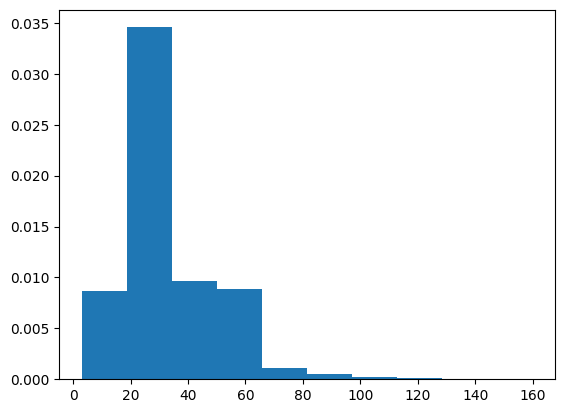

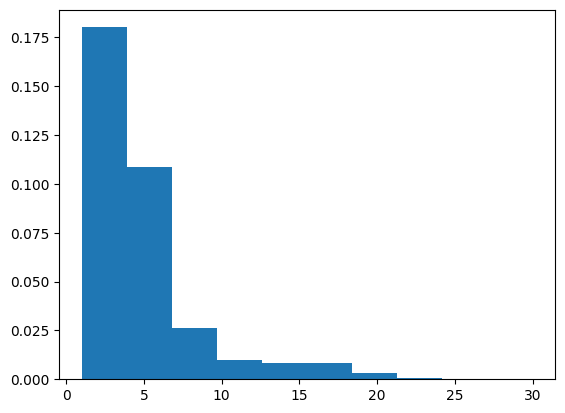

In [15]:
import matplotlib.pyplot as plt

q_lengths, a_lengths = [], []
for q, a in arithmetic_easy:
  q_lengths.append(len(q))
  a_lengths.append(len(a))


plt.hist(q_lengths, density=True)
plt.show()
plt.hist(a_lengths, density=True)
plt.show()

## Exploring Token Embeddings and Attention Masks

In [16]:
transformer = Transformer(
    TokenEmbedding(arithmetic_easy_tokens, 6),  # 6 = d_model
    30,   # = max_output_length
    5,    # = n_encoder_layers
    5,    # = n_decoder_layers
    1,    # = n_heads
    1024  # = d_ff
)

In [17]:
sample_questions = [arithmetic_easy[i][0] for i in range(5)]
sample_questions

['What is -5 - 110911?',
 'What is -0.188 + -0.814?',
 'Sum 259 and -46.',
 'Sum -10 and -52539.',
 'What is the difference between -2 and 251860?']

In [18]:
sample_indices = transformer.token_embedding.indices(sample_questions)
sample_indices

tensor([[ 0, 44, 30, 23, 41,  3, 31, 40,  3,  9, 17,  3,  9,  3, 13, 13, 12, 21,
         13, 13, 22,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 44, 30, 23, 41,  3, 31, 40,  3,  9, 12, 10, 13, 20, 20,  3,  7,  3,
          9, 12, 10, 20, 13, 16, 22,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 40, 42, 34,  3, 14, 17, 21,  3, 23, 35, 26,  3,  9, 16, 18, 10,  1,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 40, 42, 34,  3,  9, 13, 12,  3, 23, 35, 26,  3,  9, 17, 14, 17, 15,
         21, 10,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 44, 30, 23, 41,  3, 31, 40,  3, 41, 30, 27,  3, 26, 31, 28, 28, 27,
         39, 27, 35, 25, 27,  3, 24, 27, 41, 44, 27, 27

In [19]:
sample_unembedded = transformer.token_embedding.unembed(sample_indices)
sample_unembedded

['what is -5 - 110911?',
 'what is -0.188 + -0.814?',
 'sum 259 and -46.',
 'sum -10 and -52539.',
 'what is the difference between -2 and 251860?']

In [20]:
sample_unembedded_special = transformer.token_embedding.unembed(
    sample_indices, include_special=True
)
sample_unembedded_special

['<START>what is -5 - 110911?<END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<START>what is -0.188 + -0.814?<END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<START>sum 259 and -46.<END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<START>sum -10 and -52539.<END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<START>what is the difference between -2 and 251860?<END>']

In [21]:
sample_token_embeddings = transformer.token_embedding(sample_indices)
sample_token_embeddings

tensor([[[-5.6530,  2.9861,  0.0335, -1.2978, -3.2770, -3.3343],
         [ 2.4446,  5.3501, -5.4558, -1.4338,  1.4089, -0.3575],
         [ 3.9087,  0.5899,  0.2817, -0.8572,  5.7560, -0.5077],
         ...,
         [-0.2730,  2.0286, -0.2353,  1.7067,  3.6919,  0.1826],
         [-0.2730,  2.0286, -0.2353,  1.7067,  3.6919,  0.1826],
         [-0.2730,  2.0286, -0.2353,  1.7067,  3.6919,  0.1826]],

        [[-5.6530,  2.9861,  0.0335, -1.2978, -3.2770, -3.3343],
         [ 2.4446,  5.3501, -5.4558, -1.4338,  1.4089, -0.3575],
         [ 3.9087,  0.5899,  0.2817, -0.8572,  5.7560, -0.5077],
         ...,
         [-0.2730,  2.0286, -0.2353,  1.7067,  3.6919,  0.1826],
         [-0.2730,  2.0286, -0.2353,  1.7067,  3.6919,  0.1826],
         [-0.2730,  2.0286, -0.2353,  1.7067,  3.6919,  0.1826]],

        [[-5.6530,  2.9861,  0.0335, -1.2978, -3.2770, -3.3343],
         [-0.1036,  1.5104, -6.8446,  4.8069, -0.1835, -1.4648],
         [-4.8159, -1.4185, -2.8177,  1.9061, -8.7705,  0.

In [22]:
def print_full(matrix, digits='.02f'):
  for r in range(matrix.shape[0]):
    for c in range(matrix.shape[1]):
      print(f'{float(matrix[r, c]):{digits}}', end=' ')
    print()
  print()


mask = transformer.input_attention_mask(sample_indices)
for index_seq, mask in zip(sample_indices, mask):
  print('Token sequence indices and input mask matrix')
  print_full(torch.cat([index_seq[None], mask]), digits='g')

  print('Post-softmax')
  print_full(torch.nn.functional.softmax(mask, dim=1), digits='.4f')

Token sequence indices and input mask matrix
0 44 30 23 41 3 31 40 3 9 17 3 9 3 13 13 12 21 13 13 22 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -i

In [23]:
sample_outputs = [arithmetic_easy[i][1] for i in range(5)]
sample_output_indices = transformer.token_embedding.indices(sample_outputs)

In [24]:
sample_outputs

['-110916', '-1.002', '213', '-52549', '251862']

In [25]:
sample_output_indices

tensor([[ 0,  9, 13, 13, 12, 21, 13, 18,  1],
        [ 0,  9, 13, 10, 12, 12, 14,  1,  2],
        [ 0, 14, 13, 15,  1,  2,  2,  2,  2],
        [ 0,  9, 17, 14, 17, 16, 21,  1,  2],
        [ 0, 14, 17, 13, 20, 18, 14,  1,  2]])

In [26]:
mask = transformer.output_attention_mask(sample_output_indices)
for index_seq, mask in zip(sample_output_indices, mask):
  print('Token sequence indices and output self-attention mask matrix')
  print_full(torch.cat([index_seq[None], mask]), digits='g')

  print('Post-softmax')
  print_full(torch.nn.functional.softmax(mask, dim=1), digits='.4f')

Token sequence indices and output self-attention mask matrix
0 9 13 13 12 21 13 18 1 
0 -inf -inf -inf -inf -inf -inf -inf -inf 
0 0 -inf -inf -inf -inf -inf -inf -inf 
0 0 0 -inf -inf -inf -inf -inf -inf 
0 0 0 0 -inf -inf -inf -inf -inf 
0 0 0 0 0 -inf -inf -inf -inf 
0 0 0 0 0 0 -inf -inf -inf 
0 0 0 0 0 0 0 -inf -inf 
0 0 0 0 0 0 0 0 -inf 
0 0 0 0 0 0 0 0 0 

Post-softmax
1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.5000 0.5000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.3333 0.3333 0.3333 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.2500 0.2500 0.2500 0.2500 0.0000 0.0000 0.0000 0.0000 0.0000 
0.2000 0.2000 0.2000 0.2000 0.2000 0.0000 0.0000 0.0000 0.0000 
0.1667 0.1667 0.1667 0.1667 0.1667 0.1667 0.0000 0.0000 0.0000 
0.1429 0.1429 0.1429 0.1429 0.1429 0.1429 0.1429 0.0000 0.0000 
0.1250 0.1250 0.1250 0.1250 0.1250 0.1250 0.1250 0.1250 0.0000 
0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 0.1111 

Token sequence indices and output self-atten

In [27]:
mask = transformer.cross_attention_mask(sample_indices, sample_output_indices)
for index_seq, mask in zip(sample_indices, mask):
  print('Token sequence indices and output cross-attention mask matrix')
  print_full(torch.cat([index_seq[None], mask]), digits='g')

  print('Post-softmax')
  print_full(torch.nn.functional.softmax(mask, dim=1), digits='.4f')

Token sequence indices and output cross-attention mask matrix
0 44 30 23 41 3 31 40 3 9 17 3 9 3 13 13 12 21 13 13 22 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 

## Transformer Training

In [32]:
from typing import Callable, List
import tqdm.notebook


def average(a, average_window):
  """
  :param a: an array
  :param average_window: size of averaging window
  :return: average over last averaging_window elements of a, or average
  of a, if len(a) < average_window, or 0 if len(a) == 0
  """
  return sum(a[-average_window:]) / max(1, min(len(a), average_window))


class ProgressBarUpdater:
  def __init__(
      self, num_epochs: int | None, num_batches: int, average_window: int
  ):
    """
    :param num_epochs: total number of training epochs. None indicates that
    batch mode is being used.
    :param num_batches: total number of training batches
    """
    tqdm_position = 0
    if num_epochs is not None:
      self.epoch_tqdm = tqdm.notebook.tqdm(
          total=num_epochs, unit='epochs', position=tqdm_position
      )
      tqdm_position += 1
    else:
      self.epoch_tqdm = None

    self.batch_tqdm = tqdm.notebook.tqdm(
        total=num_batches, unit='batches', position=tqdm_position
    )

    self.average_window = average_window

  def __call__(
      self, i_epoch: int, i_batch: int,
      losses: List[float], accuracies: List[float]
  ):
    """
    Called during training once per batch
    :param i_epoch: current epoch index
    :param i_batch: current batch index
    :param losses: list of batch losses
    :param accuracies: list of batch accuracies
    """
    if self.epoch_tqdm is not None:
      # update using epoch mode
      if i_batch == 0 and i_epoch > 0:
        self.batch_tqdm.reset()
        self.epoch_tqdm.update(1)
      else:
        self.batch_tqdm.update(1)
    else:
      # update using batch mode
      self.batch_tqdm.update(1)

    self.batch_tqdm.set_postfix_str(
        f'Current loss: {average(losses, self.average_window):.05f}, '
        + 'Current accuracy: '
        + f'{average(accuracies, self.average_window) * 100:.2f}%'
    )


class BatchProgressUpdater:
  def __init__(
      self, num_epochs: int | None, num_batches: int, average_window: int
  ):
    """
    :param num_epochs: total number of training epochs. None indicates that
    batch mode is being used.
    :param num_batches: total number of training batches
    """
    self.num_epochs = num_epochs
    self.num_batches = num_batches
    self.average_window = average_window

  def __call__(
      self, i_epoch: int, i_batch: int,
      losses: List[float], accuracies: List[float]
  ):
    """
    Called during training once per batch
    :param i_epoch: current epoch index
    :param i_batch: current batch index
    :param losses: list of batch losses
    :param accuracies: list of batch accuracies
    """
    if self.num_epochs is not None:
      epoch_str = f'Epoch {i_epoch + 1} / {self.num_epochs}. '
    else:
      epoch_str = ''
    print(
        epoch_str
        + f'Batch {i_batch + 1} / {self.num_batches}. '
        + f'Loss: {average(losses, self.average_window):.05f}. '
        + f'Accuracy: {average(accuracies, self.average_window) * 100:.2f}%'
    )


class QATransformerTrainer:
  def __init__(
      self, folder, model, data_loader, optim, loss_fn, average_window
  ):
    """
    :param folder: The folder to save model parameters in
    :param model: The model to train
    :param data_loader: An object that provides batches of data
    :param optim: optimizer object to use to train the model
    :param loss_fn: the loss function, which computes loss given prob and
    actual outputs of Transformer.forward
    :param average_window: length of loss/accuracy averaging window
    """
    self.folder = folder
    self.model = model
    self.data_loader = data_loader
    self.optim = optim
    self.loss_fn = loss_fn
    self.average_window = average_window

  def index_path(self, index: int):
    """
    :param index: index to get the path for
    :return: The file path of the given save index
    """
    return os.path.join(self.folder, f'{index}.dat')

  def save(self, index: int | None = None):
    """
    :param index: index to save model to. If None, then a new index will
    be created. Otherwise, the given index must exist in the save folder
    """
    if index is not None:
      path = self.index_path(index)
      assert os.path.exists(path)
    else:
      files = [f for f in os.listdir(self.folder) if f.endswith('.dat')]
      last_index = max(map(lambda f: int(os.path.splitext(f)[0]), files),
                       default=-1)
      path = self.index_path(last_index + 1)

    torch.save(self.model.state_dict(), path)

  def load(self, index: int):
    """
    :param index: save index to load
    Loads the model saved at the given index. Saves the current model
    before overwriting it.
    """
    path = self.index_path(index)
    assert os.path.exists(path)

    self.save()
    self.model.load_state_dict(torch.load(path))

  def train(
      self,
      epochs: int | None = None,
      batches: int | None = None,
      batch_callbacks: List[Callable[[int, int], None]] = (),
      verbosity: int = 2
  ):
    """
    :param epochs: how many epochs to train for
    :param batches: how many batches to train for (if epochs is None)
    :param batch_callbacks: a list of function to call after each batch.
    Each function should have signature
    (i_epoch: int, i_batch: int) -> None, where i_epoch and
    i_batch are the epoch and batch indices of the current epoch and batch
    :param verbosity: How verbose the progress messsage should be.
    0 = no progress messages, 1 = progress bars, 2 = one message per batch
    If both epochs and batches are None, then the function will train for
    1 epoch by default. If both are supplied, then batches is ignored.
    """

    # default to 1 epoch if no arguments are given
    if epochs is None and batches is None:
      epochs = 1

    # ignore batches argument in favor epochs
    if epochs is not None:
      batches = None

    # input validation (avoid an almost infinite loop)
    if epochs is not None:
      assert epochs > 0

    if batches is not None:
      assert batches > 0

    # training
    # create progress updater
    if verbosity == 0:
      updater = None
    elif verbosity == 1:
      num_batches = len(self.data_loader) if batches is None else batches
      updater = ProgressBarUpdater(
          epochs, num_batches, self.average_window
      )
    elif verbosity == 2:
      num_batches = len(self.data_loader) if batches is None else batches
      updater = BatchProgressUpdater(
          epochs, num_batches, self.average_window
      )

    # store losses and accuracies and return them
    batch_losses, batch_accuracies = [], []

    # put model in training mode
    self.model.train()

    # iterate over desired number of epochs or forever if using batches
    for i_epoch in range(999999999999999 if epochs is None else epochs):
      # self.data_loader is an iterable of all batches in an epoch
      for i_batch, (b_question, b_answer) in enumerate(self.data_loader):
        # exit if we have done enough batches
        if batches is not None and len(batch_losses) == batches:
          return batch_losses, batch_accuracies

        # get next-token probabilities and actual indices
        prob, actual = self.model(b_question, b_answer)

        # compute loss + gradients, and perform optimization step
        loss = self.loss_fn(prob, actual)

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        # save batch loss and accuracy
        batch_losses.append(loss.item())
        not_pads = (actual != self.model.token_embedding.pad_index).float()
        n_tokens = not_pads.sum(dim=1)
        matched = (prob.argmax(dim=1) == actual).float() * not_pads
        acc = (matched.sum(dim=1) / n_tokens).mean()
        batch_accuracies.append(acc)

        # print progress messages and run callbacks
        if updater is not None:
          updater(i_epoch, i_batch, batch_losses, batch_accuracies)

        for batch_callback in batch_callbacks:
          batch_callback(i_epoch, i_batch)

    return batch_losses, batch_accuracies

In [33]:
import time


class SavePeriodicallyCallback:
  """
  Type of callback to be passed to QATransformerTrainer.train's
  batch_callbacks option. This callback will save the model being
  every time a specified amount of time since the last save elapses.
  """

  def __init__(self, trainer: QATransformerTrainer, save_interval: float):
    """
    :param trainer: QATransformerTrainer trainer object training the model
    :param save_interval: Time in seconds between model saves.
    """
    self.trainer = trainer
    self.save_interval = save_interval
    self.last_save_time = time.time()

  def __call__(self, i_epoch, i_batch):
    """
    Saves the model if self.save_interval seconds have elapsed since
    the last save
    :param i_epoch: current epoch index
    :param i_batch: current batch index
    """
    if time.time() - self.last_save_time >= self.save_interval:
      self.trainer.save()
      self.last_save_time = time.time()


class WarmupLRScheduleCallback:
  """
  Callback to be passed to the callbacks option of
  QATransformerTrainer.train. This callback sets the learning rate of the
  optimizer according the schedule in Vaswani et al. (section 5.3)
  """

  def __init__(self, warmup_steps: int, d: int, optim, base_lr: float = 1.0):
    """
    :param warmup_steps: number of warmup steps
    :param d: embedding dimension of model
    :param optim: PyTorch optimizer object being used to optimize
    the model
    :param base_lr: Base learning rate to multiply by
    """
    self.warmup_steps = warmup_steps
    self.d = d
    self.optim = optim
    self.base_lr = base_lr
    self.step = 0

  def __call__(self, i_epoch: int, i_batch: int):
    """
    Advances the step counter and updates the learning rate of the
    optimizer according to schedule in Vaswani et al.
    :param i_epoch: current epoch index
    :param i_batch: current batch index
    """
    self.step += 1
    self.optim.lr = self.base_lr * self.d**(-.5) * min(
        self.step**(-.5), self.step * self.warmup_steps**(-1.5)
    )


In [46]:
model = Transformer(
    TokenEmbedding(arithmetic_easy_tokens, 512),
    30, 6, 6, 8, 2048, p_dropout=.1
).cuda()

ar_easy_dl = torch.utils.data.DataLoader(
    arithmetic_easy, batch_size=128, shuffle=True,
)

optim = torch.optim.Adam(
    model.parameters(),
    lr=6e-4,
    betas=(.9, .995),
    eps=1e-9
)

loss_fn = torch.nn.CrossEntropyLoss(
    ignore_index=model.token_embedding.pad_index, label_smoothing=.05
)

trainer = QATransformerTrainer('model2', model, ar_easy_dl, optim, loss_fn, 100)

# save every 900s = 15min
save_callback = SavePeriodicallyCallback(trainer, 900)

In [50]:
losses, accuracies = trainer.train(
    epochs=2,
    batch_callbacks=[save_callback],
    verbosity=1
)

  0%|          | 0/2 [00:00<?, ?epochs/s]

  0%|          | 0/23438 [00:00<?, ?batches/s]

In [47]:
trainer.load(12)

In [36]:
batch = next(iter(ar_easy_dl))

In [37]:
model.train()
prob, actual = model(batch[0], batch[1])

In [38]:
prob.shape

torch.Size([256, 47, 22])

In [39]:
actual.shape

torch.Size([256, 22])

In [57]:
model.eval()
with torch.no_grad():
    print(batch[0][50])
    print(model(batch[0][50]))

In base 9, what is 442 + -5?
tensor([-1.5149, -0.6246, -1.5795, -1.5071, -1.6892, -1.6505, -1.7726, -1.8778,
        -1.5867,  4.0158, -0.7512, -1.4037,  1.8952,  3.3266,  2.7380,  2.3791,
         2.2658,  2.2600,  1.6691,  1.7582,  1.4803,  1.2695, -1.6022, -1.0796,
        -1.2574, -1.1826, -1.4925, -1.2410, -1.6388, -1.5754, -1.7663, -1.6779,
        -1.5637, -1.5802, -1.6068, -1.5572, -1.6538, -1.6904, -1.5834, -1.7714,
        -1.5040, -1.6266, -1.6930, -1.6779, -1.7156, -1.5514, -1.5940],
       device='cuda:0')
tensor([-0.8981,  3.9388, -0.9819, -0.6913, -1.4301, -1.1849, -2.3033, -0.8399,
        -1.1060,  0.1913,  1.3431, -1.1932, -0.7594,  0.9131,  1.1400,  1.6206,
         0.8799,  1.4027,  0.8400,  1.1394, -0.5853, -0.0760, -0.9776, -2.2735,
        -1.5882, -1.6100, -1.6587, -0.9358, -1.3828, -0.9994, -1.3601, -1.2240,
        -0.9191, -1.2290, -0.9951, -0.9989, -1.4705, -1.0713, -0.7547, -1.5517,
        -0.8162, -1.0285, -0.9250, -1.1235, -0.7338, -0.9410, -1.1143],
   

In [56]:
model.train()
prob, actual = model(batch[0][20:21], batch[1][20:21])
print(prob.argmax(dim=1))
print(actual)

tensor([[ 9, 10, 10, 20,  1]], device='cuda:0')
tensor([[14, 17, 10, 18,  1]], device='cuda:0')
